<a href="https://colab.research.google.com/github/amalphonse/Bertelsmann-60DaysUdacity/blob/master/SimpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

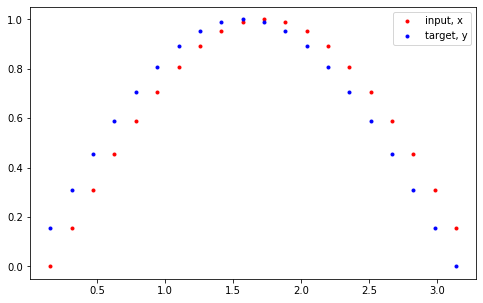

In [2]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()


In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

In [4]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [5]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [0]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)


In [0]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

Loss:  0.7172032594680786


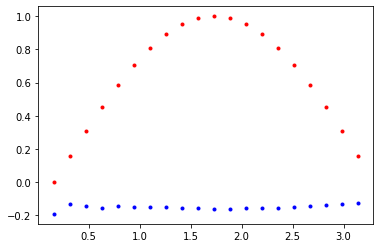

Loss:  0.04402909055352211


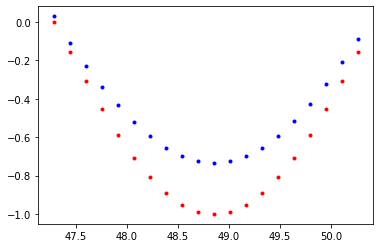

Loss:  0.010034777224063873


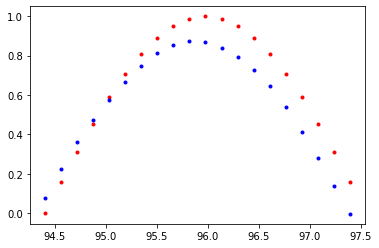

Loss:  6.836381362518296e-05


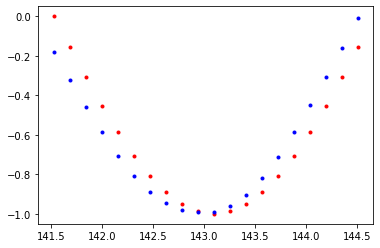

Loss:  0.00030403825803659856


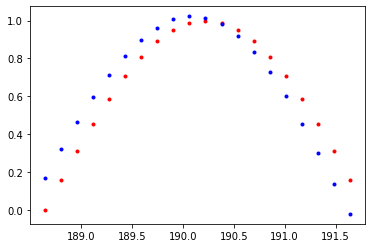

In [9]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)